# Stock Price Prediction

Context: Instead of using the actual stock price as features, use returns of a company instead. 

# Preparation

## Imports

Importing the libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series libraries
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# NLTK
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Importing the data

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Preprocessing

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def read_csv_from_company(company_name):
    """
        PRECONDITION: FILE NAME MUST BE IN 'COMPANY_NAME.csv', e.g. 'GOOGL.csv'
    """
    filename = company_name + '.csv'
    filepath  = '/content/drive/My Drive/CS3244/Colab/datasets_zx/' + filename
    raw_df = pd.read_csv(filepath, index_col="date", parse_dates=True)
    raw_df = raw_df.resample('B').pad()
    raw_df.index.freq = 'B'
    return raw_df


def update_df_sentiment(df):
    """
        Removes the news column from the dataframe and replaces it with the respective sentiments
    """
    sid = SentimentIntensityAnalyzer()
    for date, row in df.iterrows():
        news = row['main_news']
        sentimentdict = sid.polarity_scores(str(news))
        for sentiment, value in sentimentdict.items():
            df.at[date, sentiment] = value
    df.drop('main_news', axis=1, inplace=True)
    return df


def create_df(raw_df, num_days, 
              include_prices=None, include_returns=None, include_hl=None, include_volume=None,
              classify=None):
    """
        Creates the dataframe based on the specified requirements. 
    """
    # Select all the features that need to be included
    col_list = ['neg','neu','pos','compound']
    if include_prices == True:
        col_list += ['close']
    if include_hl == True:
        col_list += ['high','low']
    if include_volume == True:
        col_list += ['volume']
    df = raw_df.copy()[col_list]
    if include_returns == True:
        df['returns'] = raw_df['close'].pct_change()
        df = df.iloc[1:]
        col_list += ['returns']

    # Create a sliding window
    for i in range(1,num_days):
        for col in col_list:
            col_name = col + '_' + str(i)
            df[col_name] = df[col].shift(i)
        df = df.iloc[num_days:]

    # Create the label (target)
    # If the target is price prediction
    if include_prices == True:
        df['target_price'] = df['close'].shift(-1)
        df = df.iloc[:-1]
        df['target_class'] = df['target_price'] > df['close']
        if classify == True:
            df = df.drop(columns='target_price')
        else:
            df = df.drop(columns = 'target_class')
    # If the target is prediction of returns
    elif include_returns == True:
        df['target_returns'] = df['returns'].shift(-1)
        df = df.iloc[:-1]
        df['target_class'] = df['target_returns'] > 0
        if classify == True:
            df = df.drop(columns='target_returns')
        else:
            df = df.drop(columns = 'target_class')

    return df


def get_df(company_name, num_days, 
           include_prices=None, include_returns=None, include_hl=None, include_volume=None,
           classify=None):
    raw_df = read_csv_from_company(company_name)
    raw_df = update_df_sentiment(raw_df)
    df = create_df(raw_df, num_days, include_prices, include_returns, include_hl, include_volume, classify)
    return df

def get_df_sentiment_only(company_name, num_days):
    df_with_prices = get_df(company_name, num_days, include_prices=True, 
                            include_returns=False, include_hl = False,
                            include_volume = False, classify = True)
    df_with_prices.drop('close', axis=1, inplace=True)
    for day in range(1, num_days):
        col_to_drop = 'close_' + str(day)
        df_with_prices.drop(col_to_drop, axis=1, inplace=True)
    return df_with_prices

### Creating the dataframe
Inputs for `get_df`:
*   `company_name`: e.g. `'GOOGL'`, `'MSFT'` or `'FB'`
*   `raw_df`:  The raw dataframe (i.e. the imported data)
*   `num_days`: The number of days in the sliding window. E.g. if it is set to 2, it will include the data for day n and day n-1.
*   `include_prices` (optional): Set to `True` if you wish to include prices
*   `include_returns` (optional): Set to `True` if you wish to include returns
*   `include_hl` (optional): Set to `True` if you wish to include the high and low values
*   `include_volume` (optional): Set to `True` if you wish to include the trading volume
*   `classify` (optional): Set to `True` if you wish to train a classification model. By default, it will be a time series regression model.

#### Demonstration

If you intend to try out the function, modify the function params in the demo tab :)

In [0]:
#test
"""
google_remp = get_df('GOOGL', 3,
                     include_prices=True, 
                     include_returns=False, 
                     include_hl = False,
                     include_volume = False,
                     classify = True)
google_remp.head()
"""
google_sentiment_only = get_df_sentiment_only('GOOGL',3)
google_sentiment_only.head()

,neg,neu,pos,compound,neg_1,neu_1,pos_1,compound_1,neg_2,neu_2,pos_2,compound_2,target_class
date,,,,,,,,,,,,,
2013-02-18,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000,1.000,0.0,0.0000,True
2013-02-19,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000,1.000,0.0,0.0000,False
2013-02-20,0.045,0.955,0.000,-0.1027,0.000,1.000,0.000,0.0000,0.000,1.000,0.0,0.0000,True
2013-02-21,0.000,0.951,0.049,0.0772,0.045,0.955,0.000,-0.1027,0.000,1.000,0.0,0.0000,True
2013-02-22,0.000,1.000,0.000,0.0000,0.000,0.951,0.049,0.0772,0.045,0.955,0.0,-0.1027,False


### Concaternating data for companies

Change this part depending on which companies to use

In [0]:
num_days = 3
include_prices = False 
include_returns = True
include_hl = True
include_volume = True
classify = True
df_google = get_df('GOOGL', num_days, include_prices, include_returns, include_hl, include_volume, classify)
df_fb = get_df('FB', num_days, include_prices, include_returns, include_hl, include_volume, classify)
df_microsoft = get_df('MSFT', num_days, include_prices, include_returns, include_hl, include_volume, classify)
df = pd.concat([df_google,df_fb,df_microsoft])

#df = df_google

# Classification Models

## Data for classification models
This will be the dataframe that will be used to train and test the models. We have chosen to keep all features and use a time frame of 3 days. 

In [0]:
numvar = 4 # Number of variables which are set to true
input_dim = num_days * (4+numvar)

num_trials=20 #For some reason accuracy changes with each run. We will average the accuracy over 20 runs.

## KNN Classifier

In [0]:
num_neighbors = 5

No dimensionality reduction

In [13]:
from sklearn.neighbors import KNeighborsClassifier

df_KNN = df.copy()

y = df_KNN['target_class']
x = df_KNN.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

accumulated_accuracy = 0
for i in range(num_trials):
    classifier = KNeighborsClassifier(n_neighbors=num_neighbors)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    accumulated_accuracy += classifier.score(x_test, y_test)
print(accumulated_accuracy/num_trials)

0.5083655083655081


With dimensionality reduction

In [14]:
from sklearn.decomposition import PCA

y = df_KNN['target_class']
x = df_KNN.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Reduce number of features
n_components = int(input_dim/4)
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=12).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Then scale
scaler = MinMaxScaler()
scaler.fit(x_train_pca)
x_train_pca = scaler.transform(x_train_pca)
x_test_pca = scaler.transform(x_test_pca)

accumulated_accuracy = 0
for i in range(num_trials):
    classifier = KNeighborsClassifier(n_neighbors=num_neighbors)
    classifier.fit(x_train_pca, y_train)
    y_pred = classifier.predict(x_test_pca)
    accumulated_accuracy += classifier.score(x_test_pca, y_test)
print(accumulated_accuracy/num_trials)

0.510939510939511


## Random Forest Classifier

0.5045045045045045


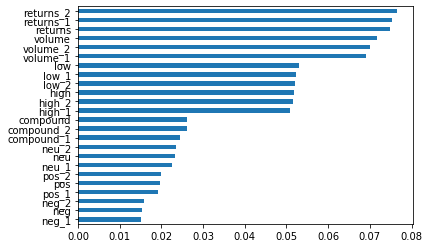

In [51]:
from sklearn.ensemble import RandomForestClassifier
df_RF = df.copy()

# limit = 100000 # limit samples
y = df_RF['target_class']
x = df_RF.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

"""
accumulated_accuracy = 0
for i in range(num_trials):
    classifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    accumulated_accuracy += classifier.score(x_test, y_test)
print(accumulated_accuracy/num_trials)
"""
classifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classifier.score(x_test, y_test))

feat_importances = pd.Series(classifier.feature_importances_, index=x.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')

## Neural Network Classifier

In [0]:
from keras import optimizers
from sklearn.preprocessing import StandardScaler

df_NN = df.copy()
y = df_NN['target_class']
x = df_NN.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = Sequential()
model.add(Dropout(0.2, input_shape=(input_dim,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, epochs=200, batch_size=30)
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

y_pred = model.predict(x_test)

In [0]:
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

df_NN2 = df.copy()

y = df_NN2['target_class']
x = df_NN2.drop(['target_class'], axis=1)
sc = StandardScaler()
x = sc.fit_transform(x)

def create_network():
    model = Sequential()
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(input_dim,)))
    model.add(Dense(5, input_dim=6, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=20, 
                                 verbose=0)

score = cross_val_score(neural_network, x, y, cv=5)
print(score)
sum = 0
for i in range(len(score)):
    sum += score[i]
print(sum/len(score))

[0.49805447 0.46484375 0.4921875  0.51171875 0.51171875]
0.4957046447117026


## AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
df_ada = df.copy()

y = df_ada['target_class']
x = df_ada.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

# Time Series Regression Models

## Data for Time Series Models

In [0]:
"""
df = create_df(raw_df,3,
               include_prices=True, 
               include_returns=True,
               include_hl = True,
               include_volume = True,
               classify = False)
df.head(10)
"""

## KNN Regressor

In [0]:
from sklearn.neighbors import KNeighborsRegressor
y = df['target_price']
x = df.drop(['target_price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
regressor.score(x_test, y_test)

-4.062033920412294

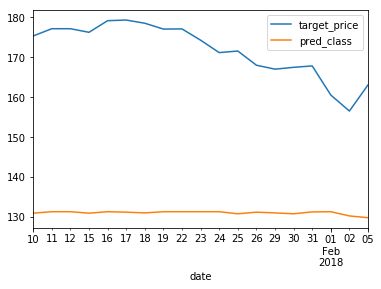

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_price'])
y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
y_test = y_test.iloc[:-1]
y_test['date'] = pd.to_datetime(y_test['date'])
y_test.set_index('date', inplace=True)
y_test.sort_index(inplace=True)
y_test.loc['2018-01-10':].plot()